<a href="https://colab.research.google.com/github/nafizahamed8/NVIDIA-Stock-Price-Forecasting-Models/blob/main/Nafiz_Uddin_Ahamed_Stock_Price_Forecasting_Analysis_Using_ARIMA_and_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#***ARIMA***

#Library Imports and Setup

In [ ]:
import math                    # Provides access to mathematical functions (e.g., trigonometry, logarithms, etc.)
import random                  # For generating random numbers and making random selections
import datetime as dt          # To work with date and time objects, aliased as 'dt' for convenience
import numpy as np             # NumPy for working with arrays and numerical computations
import pandas as pd            # Pandas for data manipulation and analysis (mainly working with DataFrames)
import matplotlib.dates as mdates  # Helper functions to handle dates with Matplotlib
import matplotlib.pyplot as plt  # Pyplot from Matplotlib for creating static, animated, and interactive visualizations

In [ ]:
!pip install yfinance

#Data Download and Initial Setup

In [ ]:
import yfinance as yf
ticker_symbol='NVDA'
start_date='2020-01-01'
end_date='2025-10-02'
nvidia_data=yf.download(ticker_symbol,start_date,end_date)

[*********************100%***********************]  1 of 1 completed


In [ ]:
nvidia_data.head()

Price,Close,High,Low,Open,Volume
Ticker,NVDA,NVDA,NVDA,NVDA,NVDA
Date,,,,,
2020-01-02,5.971409,5.971409,5.892010,5.942537,237536000
2020-01-03,5.875831,5.919638,5.826797,5.851688,205384000
2020-01-06,5.900473,5.905700,5.756359,5.782494,262636000
2020-01-07,5.971908,6.017706,5.883797,5.928848,314856000
2020-01-08,5.983109,6.024426,5.927603,5.967677,277108000


In [ ]:
nvidia_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1445 entries, 2020-01-02 to 2025-10-01
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   (Close, NVDA)   1445 non-null   float64
 1   (High, NVDA)    1445 non-null   float64
 2   (Low, NVDA)     1445 non-null   float64
 3   (Open, NVDA)    1445 non-null   float64
 4   (Volume, NVDA)  1445 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 67.7 KB


#Data Preprocessing
#Converts the Date index to a regular column,Makes Date accessible for plotting and manipulation,Ensures Date column is proper datetime format

In [ ]:
nvidia_data=nvidia_data.reset_index()
nvidia_data['Date'] = pd.to_datetime(nvidia_data['Date'])

#Initial Data Visualization

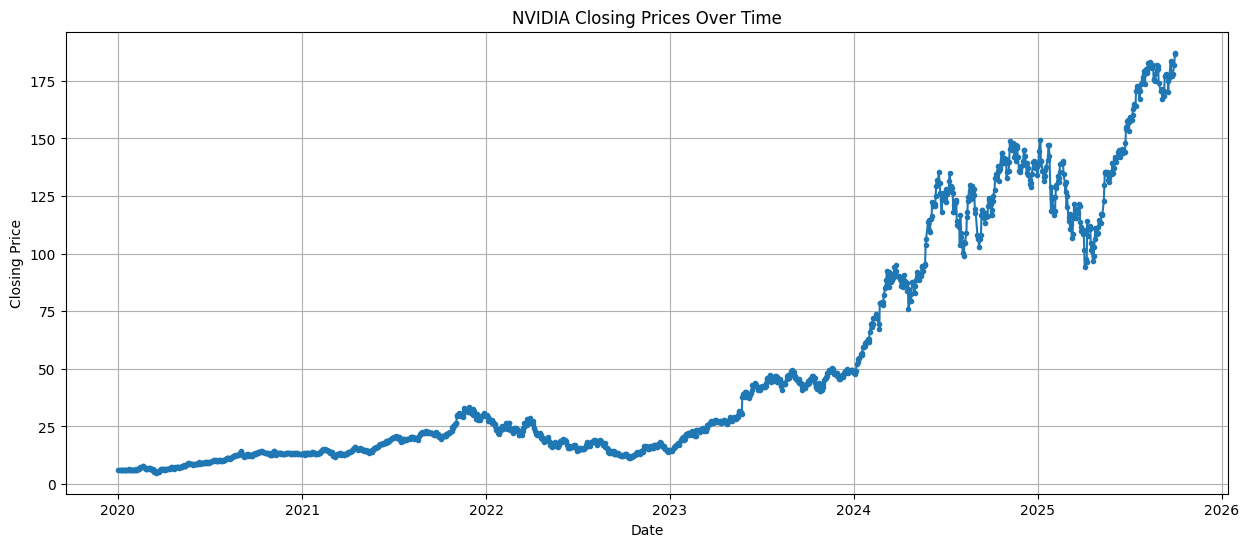

In [ ]:
plt.figure(figsize=(15,6))
plt.plot(nvidia_data['Date'], nvidia_data['Close'], marker='.')
plt.title('NVIDIA Closing Prices Over Time')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.grid(True)
plt.show()

#Calculates 90-day moving average

In [ ]:
nvidia_data['MA90']=nvidia_data['Close'].rolling(window=90).mean()

#Comparative Visualization

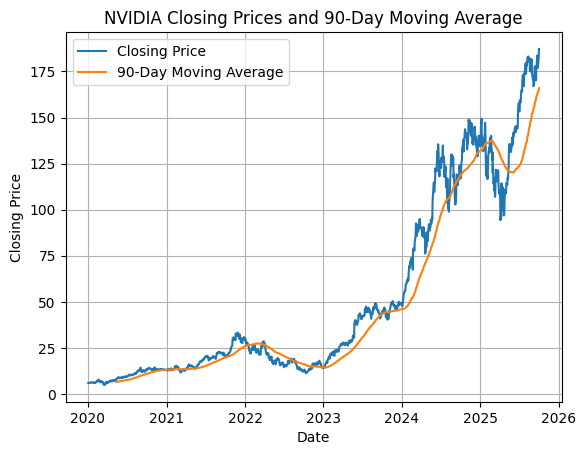

In [ ]:
plt.plot(nvidia_data['Date'], nvidia_data['Close'], label='Closing Price')
plt.plot(nvidia_data['Date'], nvidia_data['MA90'], label='90-Day Moving Average')
plt.title('NVIDIA Closing Prices and 90-Day Moving Average')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
new_nvidia_data=nvidia_data.reset_index()['Close']
new_nvidia_data

Ticker,NVDA
0,5.971409
1,5.875831
2,5.900473
3,5.971908
4,5.983109
...,...
1440,177.690002
1441,178.190002
1442,181.850006
1443,186.580002


In [ ]:
new_nvidia_data.isnull().sum()

,0
Ticker,
NVDA,0


#Stationarity Testing,Implements Augmented Dickey-Fuller test for stationarity

In [ ]:
from statsmodels.tsa.stattools import adfuller
adf_test=adfuller(new_nvidia_data)
print(f'ADF Statistic: {adf_test[0]}')
print(f'p-value: {adf_test[1]}')

ADF Statistic: 1.1494986429241338
p-value: 0.9956177010561481


#Data Differencing,Creates first differences to make data stationary

In [ ]:
diff_data=new_nvidia_data.diff().dropna()
adf_test=adfuller(diff_data)
print(f'ADF Statistic: {adf_test[0]}')
print(f'p-value: {adf_test[1]}')

ADF Statistic: -6.996213428553978
p-value: 7.522106829794674e-10


#Stationarity Visualization

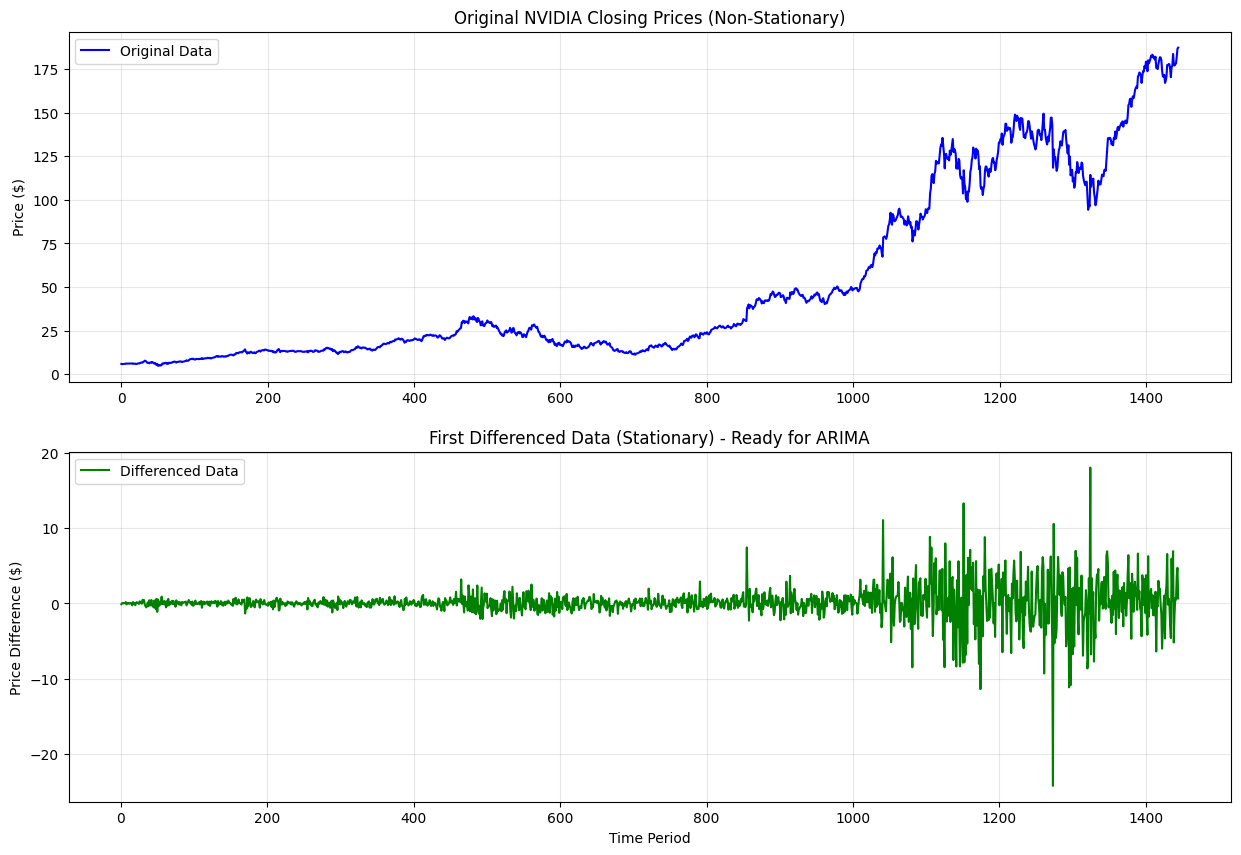

In [ ]:
plt.figure(figsize=(15, 10))

# Plot 1: Original Data
plt.subplot(2, 1, 1)
plt.plot(new_nvidia_data.index, new_nvidia_data, color='blue', linewidth=1.5)
plt.title('Original NVIDIA Closing Prices (Non-Stationary)')
plt.ylabel('Price ($)')
plt.grid(True, alpha=0.3)
plt.legend(['Original Data'], loc='upper left')
# Plot 2: Differenced Data (Stationary)
plt.subplot(2, 1, 2)
plt.plot(diff_data.index, diff_data, color='green', linewidth=1.5)
plt.title('First Differenced Data (Stationary) - Ready for ARIMA')
plt.xlabel('Time Period')
plt.ylabel('Price Difference ($)')
plt.grid(True, alpha=0.3)
plt.legend(['Differenced Data'], loc='upper left')

#ARIMA Parameter Determination
#Creates 2 vertical subplots for ACF and PACF

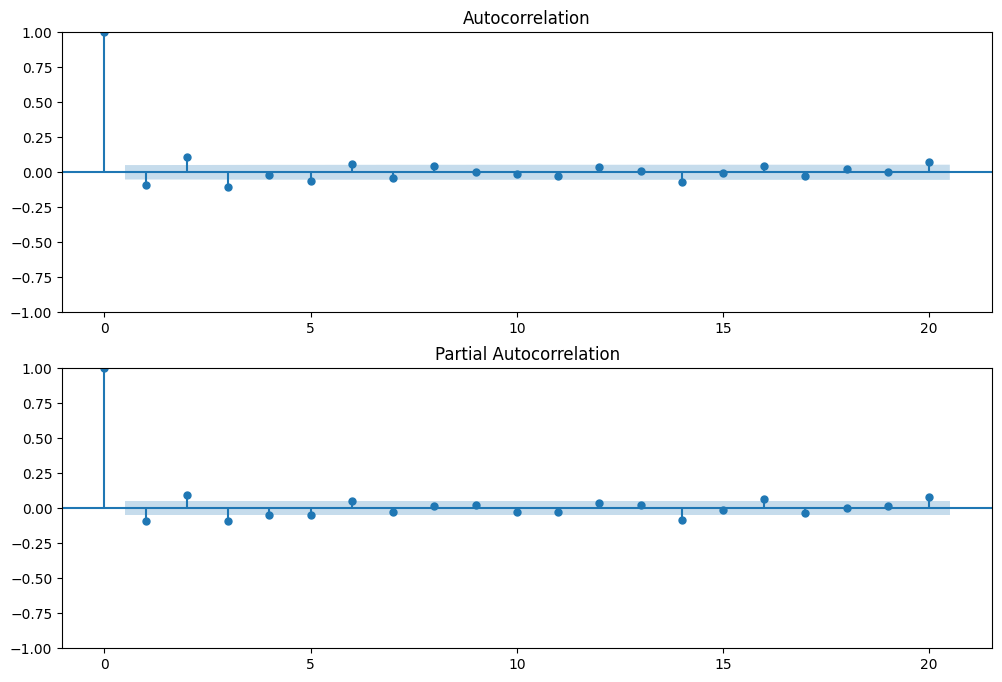

In [ ]:
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Plot ACF and PACF to determine p and q
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))
plot_acf(diff_data, ax=ax1, lags=20)  # Use differenced data
plot_pacf(diff_data, ax=ax2, lags=20)
plt.show()

#ARIMA Model Implementation

In [ ]:
from statsmodels.tsa.arima.model import ARIMA
import warnings
warnings.filterwarnings('ignore')

In [ ]:
forecast_horizon = 1  # Predict next day only
train_size = int(len(new_nvidia_data) * 0.8)
train_data = new_nvidia_data[:train_size].values  # Convert to numpy array
test_data = new_nvidia_data[train_size:].values   # Convert to numpy array

In [ ]:
print(f"Training data size: {len(train_data)}")
print(f"Test data size: {len(test_data)}")

Training data size: 1156
Test data size: 289


In [ ]:
predictions = []
actual_values = []
model_errors = []

#Rolling Window Forecasting Loop,Iterates through each point in test set,Creates ARIMA(0,1,0) model (Random Walk),Generates prediction for next time period,Stores predictions and actual values for comparison

In [ ]:
for i in range(len(test_data)):
    try:
        # Current training window (expands with each iteration)
        # Use up to but not including the current test point
        current_train = np.concatenate([train_data, test_data[:i]])

        # Fit ARIMA model
        model = ARIMA(current_train, order=(0, 1, 0))  # Using optimal parameters
        model_fit = model.fit()

        # Forecast next value
        forecast = model_fit.forecast(steps=forecast_horizon)
        predictions.append(forecast[0])
        actual_values.append(test_data[i])  # Direct array indexing

    except Exception as e:
        # Handle model fitting errors
        print(f"Error at iteration {i}: {e}")
        # Use last prediction or simple fallback
        if predictions:
            predictions.append(predictions[-1])
        else:
            predictions.append(current_train[-1])
        actual_values.append(test_data[i])
        model_errors.append(i)


In [ ]:
predictions = np.array(predictions)
actual_values = np.array(actual_values)

In [ ]:
print(f"Successful predictions: {len(predictions)}")
print(f"Model errors: {len(model_errors)}")
print(f"Test data coverage: {len(predictions)}/{len(test_data)}")

Successful predictions: 289
Model errors: 0
Test data coverage: 289/289


#Model Evaluation

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Calculate metrics
mae = mean_absolute_error(actual_values, predictions)
rmse = np.sqrt(mean_squared_error(actual_values, predictions))
mape = np.mean(np.abs((actual_values - predictions) / actual_values)) * 100

print(f'MAE: {mae:.2f}')
print(f'RMSE: {rmse:.2f}')
print(f'MAPE: {mape:.2f}%')

MAE: 2.99
RMSE: 4.05
MAPE: 19.11%


#Results Visualization

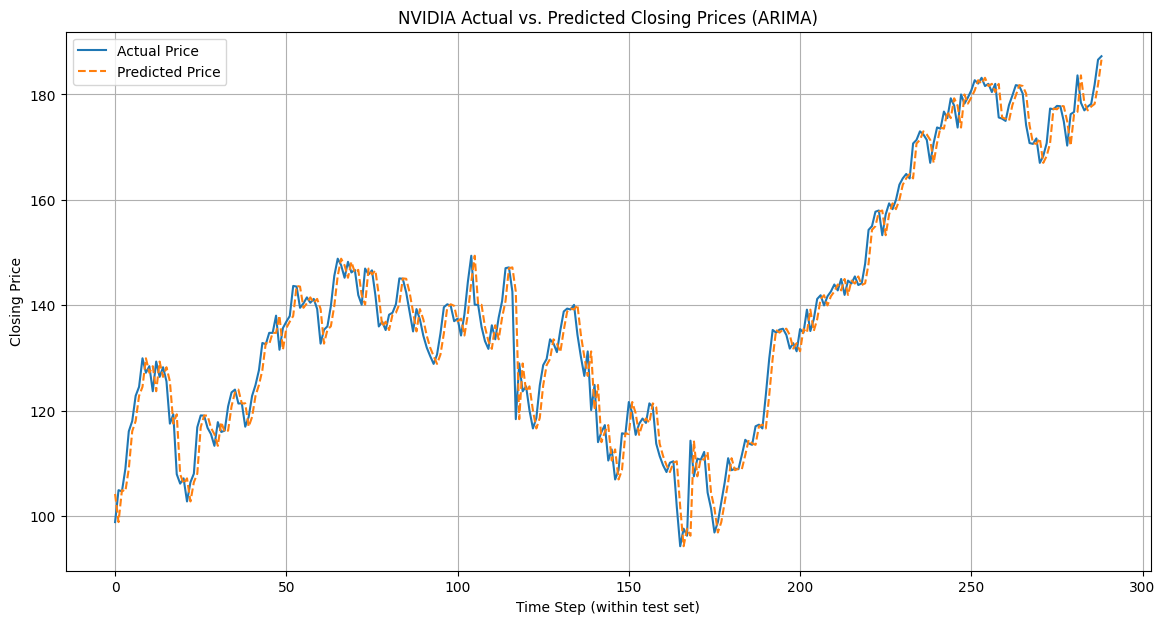

In [ ]:
plt.figure(figsize=(14, 7))
plt.plot(actual_values, label='Actual Price')
plt.plot(predictions, label='Predicted Price', linestyle='--')
plt.title('NVIDIA Actual vs. Predicted Closing Prices (ARIMA)')
plt.xlabel('Time Step (within test set)')
plt.ylabel('Closing Price')
plt.legend()
plt.grid(True)
plt.show()

#Key Workflow Summary:
Data Collection: Download NVIDIA stock data

Exploration: Visualize trends and patterns

Preprocessing: Check stationarity and apply differencing

Model Identification: Use ACF/PACF to determine ARIMA parameters

Forecasting: Implement rolling window predictions

Evaluation: Calculate error metrics to assess performance

Visualization: Compare predictions against actual values

#***LSTM***

# Import all required libraries for data processing, ML, and visualization
# Includes PyTorch for LSTM, yfinance for stock data, and sklearn for metrics

In [ ]:
# Import required libraries
import math
import random
import datetime as dt
import numpy as np
import pandas as pd
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import warnings
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cpu


# Download historical NVIDIA stock price data from Yahoo Finance
# Sets date range from 2020-01-01 to 2025-10-02 for analysis

In [ ]:
# Download NVIDIA stock data
ticker_symbol = 'NVDA'
start_date = '2020-01-01'
end_date = '2025-10-02'
nvidia_data = yf.download(ticker_symbol, start=start_date, end=end_date)

print("Data downloaded successfully!")
print(f"Data shape: {nvidia_data.shape}")

[*********************100%***********************]  1 of 1 completed

Data downloaded successfully!
Data shape: (1445, 5)


# Clean and prepare the data for time series analysis
# Convert dates to proper format and extract closing prices

In [ ]:
# Reset index and convert Date to datetime
nvidia_data = nvidia_data.reset_index()
nvidia_data['Date'] = pd.to_datetime(nvidia_data['Date'])

# Extract closing prices
new_nvidia_data = nvidia_data.reset_index()['Close']

print(f"Total data points: {len(new_nvidia_data)}")
print(f"Data range: {nvidia_data['Date'].min().date()} to {nvidia_data['Date'].max().date()}")
print(f"Missing values: {new_nvidia_data.isnull().sum()}")

Total data points: 1445
Data range: 2020-01-02 to 2025-10-01
Missing values: Ticker
NVDA    0
dtype: int64


# Plot NVIDIA's historical closing prices to visualize trends
# Shows price movements over the entire time period

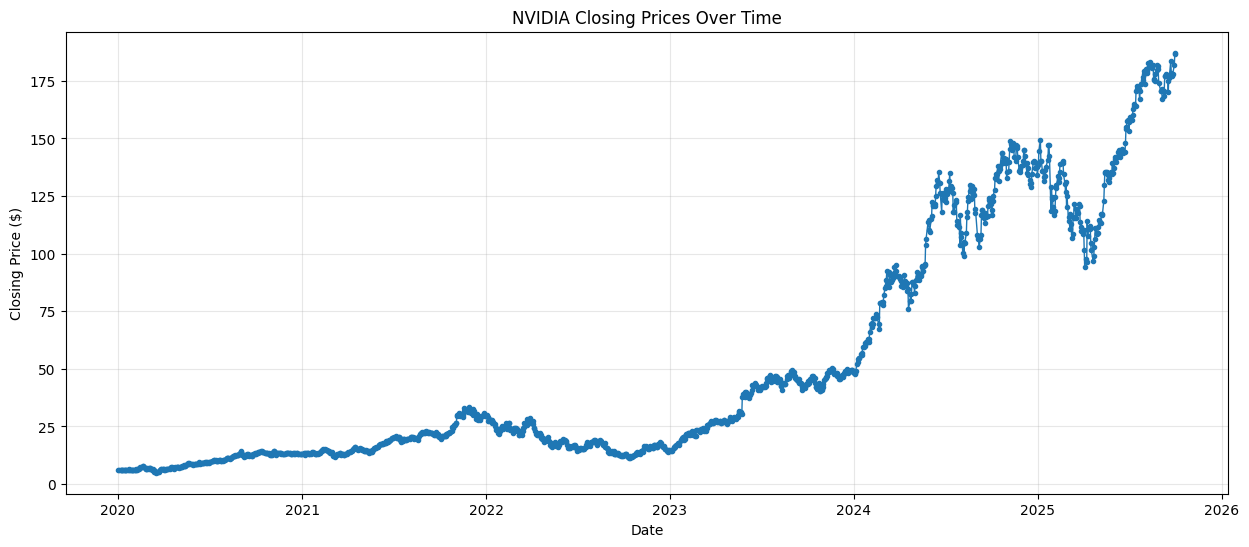

In [ ]:
# Plot original closing prices
plt.figure(figsize=(15,6))
plt.plot(nvidia_data['Date'], nvidia_data['Close'], marker='.', linewidth=1)
plt.title('NVIDIA Closing Prices Over Time')
plt.xlabel('Date')
plt.ylabel('Closing Price ($)')
plt.grid(True, alpha=0.3)
plt.show()

# Add and plot 90-day moving average to identify long-term trends
# Helps smooth out short-term price fluctuations

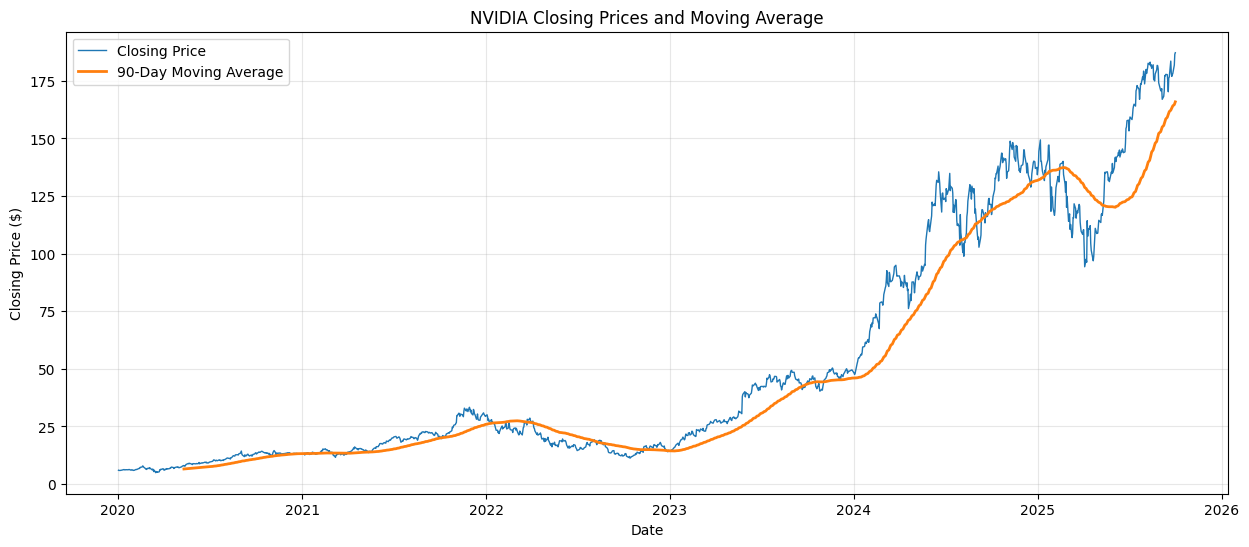

In [ ]:
# Calculate and plot 90-day moving average
nvidia_data['MA90'] = nvidia_data['Close'].rolling(window=90).mean()

plt.figure(figsize=(15,6))
plt.plot(nvidia_data['Date'], nvidia_data['Close'], label='Closing Price', linewidth=1)
plt.plot(nvidia_data['Date'], nvidia_data['MA90'], label='90-Day Moving Average', linewidth=2)
plt.title('NVIDIA Closing Prices and Moving Average')
plt.xlabel('Date')
plt.ylabel('Closing Price ($)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Scale stock prices to 0-1 range for LSTM training
# Normalization improves neural network performance and convergence

In [ ]:
# Normalize the data for LSTM
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(new_nvidia_data.values.reshape(-1, 1)).flatten()

# Access the scalar value from the numpy array before formatting
print(f"Original data range: {new_nvidia_data.iloc[0].values[0]:.2f} to {new_nvidia_data.iloc[-1].values[0]:.2f}")
print(f"Scaled data range: {scaled_data.min():.3f} to {scaled_data.max():.3f}")

Original data range: 5.97 to 187.24
Scaled data range: 0.000 to 1.000


# Create PyTorch LSTM neural network architecture
# Simple 1-layer LSTM with dropout to prevent overfitting

In [ ]:
class SimpleLSTMModel(nn.Module):
    def __init__(self, input_size=1, hidden_size=16, output_size=1, dropout=0.3):
        super(SimpleLSTMModel, self).__init__()
        self.hidden_size = hidden_size

        # Single LSTM layer
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)

        # Dropout for regularization
        self.dropout = nn.Dropout(dropout)
        self.linear = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        # LSTM layer
        lstm_out, (hidden, cell) = self.lstm(x)

        # Use the last output
        last_output = lstm_out[:, -1, :]

        # Apply dropout and linear layer
        output = self.dropout(last_output)
        output = self.linear(output)

        return output

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


# Create PyTorch Dataset class for efficient data loading
# Helper functions to convert time series into sequences for LSTM

In [ ]:
class StockDataset(Dataset):
    def __init__(self, sequences, targets):
        self.sequences = sequences
        self.targets = targets

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        return self.sequences[idx], self.targets[idx]

def create_sequences(data, sequence_length):
    """
    Create sequences for LSTM training
    """
    sequences = []
    targets = []

    for i in range(len(data) - sequence_length):
        seq = data[i:i + sequence_length]
        target = data[i + sequence_length]
        sequences.append(seq)
        targets.append(target)

    if len(sequences) > 0:
        return torch.stack(sequences), torch.stack(targets)
    else:
        return torch.tensor([]), torch.tensor([])

# Implement rolling window forecasting similar to ARIMA approach
# Retrains LSTM model for each test point with expanding training window

In [ ]:
def rolling_window_lstm_evaluation(data, sequence_length=60, train_ratio=0.8, epochs_per_window=30):
    """
    Perform rolling window evaluation similar to ARIMA approach
    """
    # Convert to tensor
    data_tensor = torch.FloatTensor(data)

    # Split into initial training and testing
    initial_train_size = int(len(data) * train_ratio)
    train_data = data_tensor[:initial_train_size]
    test_data = data_tensor[initial_train_size:]

    predictions = []
    actual_values = []
    model_history = []

    print("Starting Rolling Window LSTM Evaluation...")
    print("=" * 60)
    print(f"Initial training size: {len(train_data)}")
    print(f"Test size: {len(test_data)}")
    print(f"Sequence length: {sequence_length}")
    print(f"Epochs per window: {epochs_per_window}")
    print("-" * 60)

    # Rolling window through test data
    for i in range(len(test_data)):
        if i % 20 == 0:  # Progress update
            print(f"Processing test point {i+1}/{len(test_data)}")

        try:
            # Current training window (expanding, same as ARIMA)
            current_train = torch.cat([train_data, test_data[:i]])

            # Create sequences from current training data
            X_current, y_current = create_sequences(current_train, sequence_length)

            if len(X_current) > 0:
                # Create data loader
                current_dataset = StockDataset(X_current, y_current)
                current_loader = DataLoader(current_dataset, batch_size=16, shuffle=True)

                # Initialize and train model for this window
                window_model = SimpleLSTMModel(hidden_size=16, dropout=0.3).to(device)
                optimizer = optim.Adam(window_model.parameters(), lr=0.001, weight_decay=1e-4)
                criterion = nn.MSELoss()

                # Quick training for this window
                window_model.train()
                for epoch in range(epochs_per_window):
                    for batch_X, batch_y in current_loader:
                        batch_X, batch_y = batch_X.to(device), batch_y.to(device)
                        batch_X = batch_X.unsqueeze(-1)

                        optimizer.zero_grad()
                        outputs = window_model(batch_X)
                        loss = criterion(outputs.squeeze(), batch_y)
                        loss.backward()
                        torch.nn.utils.clip_grad_norm_(window_model.parameters(), max_norm=1.0)
                        optimizer.step()

                # Prepare sequence for prediction (last 'sequence_length' points)
                if i + sequence_length <= len(current_train):
                    prediction_sequence = current_train[-(sequence_length):].unsqueeze(0).unsqueeze(-1).to(device)

                    # Make prediction
                    window_model.eval()
                    with torch.no_grad():
                        prediction = window_model(prediction_sequence).cpu().numpy()[0, 0]

                    predictions.append(prediction)
                    actual_values.append(test_data[i].item())
                else:
                    # Not enough data for sequence, use last known value
                    predictions.append(current_train[-1].item())
                    actual_values.append(test_data[i].item())
            else:
                # Not enough sequences, use last known value
                predictions.append(current_train[-1].item())
                actual_values.append(test_data[i].item())

        except Exception as e:
            # Fallback: use last prediction or last known value
            if predictions:
                predictions.append(predictions[-1])
            else:
                predictions.append(current_train[-1].item() if 'current_train' in locals() else data_tensor[-1].item())
            actual_values.append(test_data[i].item())

    return np.array(predictions), np.array(actual_values), model_history

# Run the rolling window evaluation on NVIDIA stock data
# This step takes time as it retrains model for each prediction

In [ ]:
# Perform rolling window evaluation
print("Executing Rolling Window LSTM Evaluation...")
print("This may take a while as we retrain the model for each test point...")
print("=" * 60)

sequence_length = 60
predictions_scaled, actual_values_scaled, model_history = rolling_window_lstm_evaluation(
    scaled_data,
    sequence_length=sequence_length,
    train_ratio=0.8,
    epochs_per_window=30
)

print(f"\nRolling window evaluation completed!")
print(f"Total predictions made: {len(predictions_scaled)}")
print(f"Total test points: {len(actual_values_scaled)}")

Executing Rolling Window LSTM Evaluation...
This may take a while as we retrain the model for each test point...
Starting Rolling Window LSTM Evaluation...
Initial training size: 1156
Test size: 289
Sequence length: 60
Epochs per window: 30
------------------------------------------------------------
Processing test point 1/289
Processing test point 21/289
Processing test point 41/289
Processing test point 61/289
Processing test point 81/289
Processing test point 101/289
Processing test point 121/289
Processing test point 141/289
Processing test point 161/289
Processing test point 181/289
Processing test point 201/289
Processing test point 221/289
Processing test point 241/289
Processing test point 261/289
Processing test point 281/289

Rolling window evaluation completed!
Total predictions made: 289
Total test points: 289


# Transform predictions back to original dollar values
# Reverse the normalization applied earlier for interpretation

In [ ]:
# Convert back to original price scale
predictions_original = scaler.inverse_transform(predictions_scaled.reshape(-1, 1)).flatten()
actual_values_original = scaler.inverse_transform(actual_values_scaled.reshape(-1, 1)).flatten()

print(f"Predictions converted to original scale")
print(f"Predictions range: ${predictions_original.min():.2f} to ${predictions_original.max():.2f}")
print(f"Actual range: ${actual_values_original.min():.2f} to ${actual_values_original.max():.2f}")

Predictions converted to original scale
Predictions range: $100.68 to $178.50
Actual range: $94.30 to $187.24


# Compute MAE, RMSE, and MAPE to evaluate model performance
# Same metrics used for ARIMA model for fair comparison

In [ ]:
# Calculate metrics (same as ARIMA evaluation)
mae = mean_absolute_error(actual_values_original, predictions_original)
rmse = np.sqrt(mean_squared_error(actual_values_original, predictions_original))
mape = np.mean(np.abs((actual_values_original - predictions_original) / actual_values_original)) * 100

print('\nLSTM Rolling Window Performance:')
print('=' * 50)
print(f'MAE:  ${mae:.2f}')
print(f'RMSE: ${rmse:.2f}')
print(f'MAPE: {mape:.2f}%')


LSTM Rolling Window Performance:
MAE:  $7.89
RMSE: $9.34
MAPE: 5.71%


# Plot actual vs predicted prices to visualize forecasting accuracy
# Shows how well LSTM tracks the true stock price movements

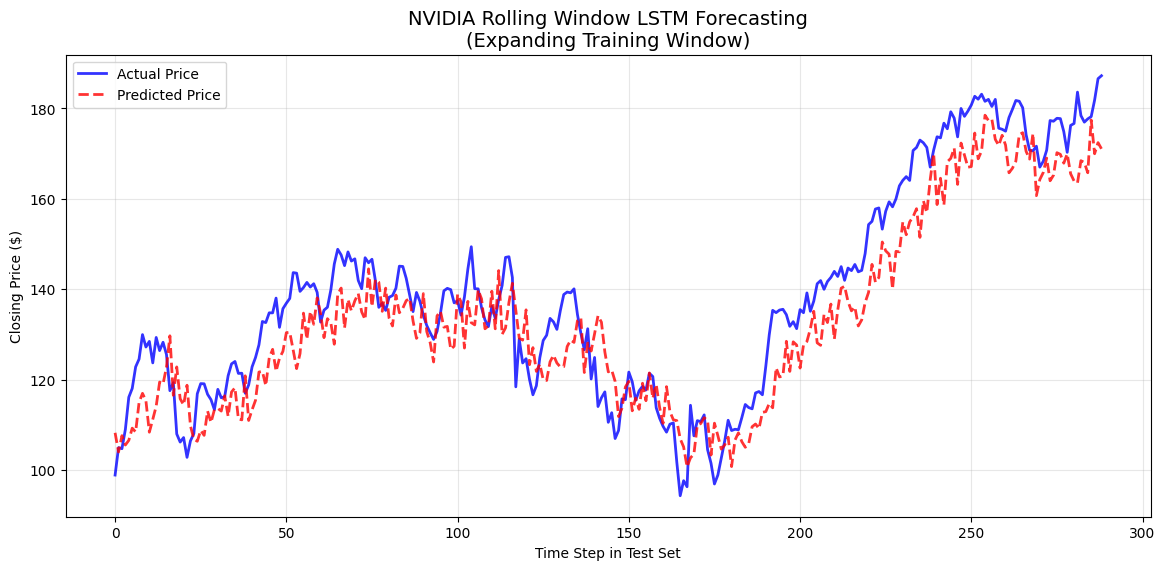

In [ ]:
# Plot actual vs predicted prices
plt.figure(figsize=(14, 6))
plt.plot(actual_values_original, label='Actual Price', linewidth=2, color='blue', alpha=0.8)
plt.plot(predictions_original, label='Predicted Price', linestyle='--', linewidth=2, color='red', alpha=0.8)
plt.title('NVIDIA Rolling Window LSTM Forecasting\n(Expanding Training Window)', fontsize=14)
plt.xlabel('Time Step in Test Set')
plt.ylabel('Closing Price ($)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Plot prediction errors over time to identify patterns
# Helps understand when the model performs well or poorly

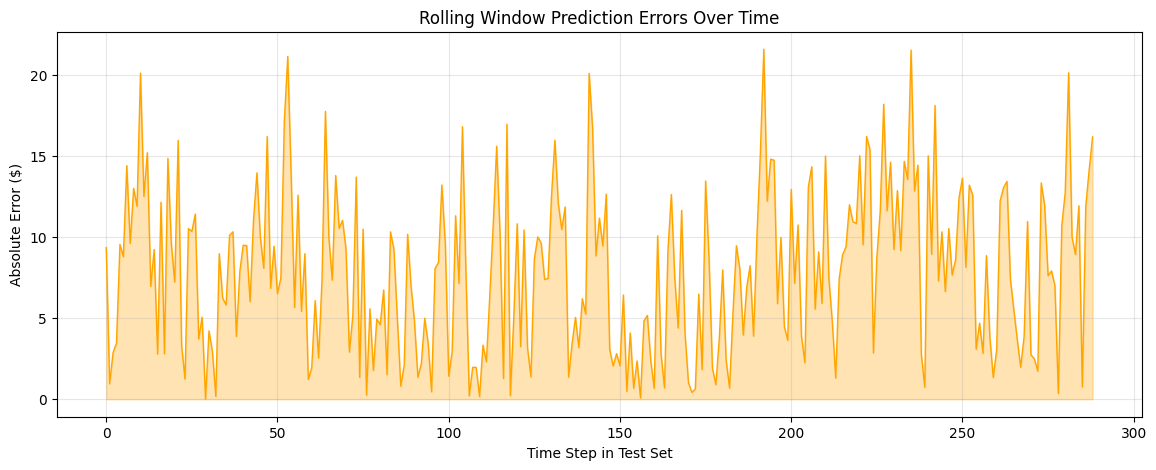

In [ ]:
# Plot prediction error over time
errors = np.abs(actual_values_original - predictions_original)
plt.figure(figsize=(14, 5))
plt.plot(errors, color='orange', linewidth=1)
plt.fill_between(range(len(errors)), errors, alpha=0.3, color='orange')
plt.title('Rolling Window Prediction Errors Over Time')
plt.xlabel('Time Step in Test Set')
plt.ylabel('Absolute Error ($)')
plt.grid(True, alpha=0.3)
plt.show()

# Calculate additional metrics like directional accuracy
# Provides deeper insights into model performance beyond basic errors

In [ ]:
# Calculate directional accuracy
direction_actual = np.diff(actual_values_original) > 0
direction_pred = np.diff(predictions_original) > 0
directional_accuracy = np.mean(direction_actual == direction_pred) * 100

print('\nDetailed Analysis:')
print('=' * 40)
print(f"Directional Accuracy: {directional_accuracy:.2f}%")
print(f"Average Error: ${mae:.2f}")
print(f"Maximum Error: ${errors.max():.2f}")
print(f"Minimum Error: ${errors.min():.2f}")
print(f"Error Standard Deviation: ${errors.std():.2f}")


Detailed Analysis:
Directional Accuracy: 48.96%
Average Error: $7.89
Maximum Error: $21.57
Minimum Error: $0.00
Error Standard Deviation: $4.99


# Compare LSTM performance with previously trained ARIMA model
# Determines which model works better for NVIDIA stock forecasting

In [ ]:
# Model performance data
models = ['ARIMA', 'LSTM']
mae_scores = [2.99, 7.89]
rmse_scores = [4.05, 9.34]
mape_scores = [19.11, 5.71]

# Create comparison table
comparison_df = pd.DataFrame({
    'Model': models,
    'MAE': mae_scores,
    'RMSE': rmse_scores,
    'MAPE': mape_scores
})

print("🤖 MODEL PERFORMANCE COMPARISON")
print("=" * 60)
print(f"{'Model':<10} {'MAE ($)':<10} {'RMSE ($)':<12} {'MAPE (%)':<12}")
print("-" * 60)

for i, row in comparison_df.iterrows():
    print(f"{row['Model']:<10} {row['MAE']:<10.2f} {row['RMSE']:<12.2f} {row['MAPE']:<12.2f}")

print("=" * 60)

🤖 MODEL PERFORMANCE COMPARISON
Model      MAE ($)    RMSE ($)     MAPE (%)    
------------------------------------------------------------
ARIMA      2.99       4.05         19.11       
LSTM       7.89       9.34         5.71        


In [ ]:
import pickle
import os

# Define file path for saving the ARIMA model
arima_model_path = 'arima_model.pkl'

# Fit ARIMA model on the entire dataset
try:
    final_arima_model = ARIMA(new_nvidia_data, order=(0, 1, 0))
    final_arima_model_fit = final_arima_model.fit()

    # Save the fitted ARIMA model
    with open(arima_model_path, 'wb') as f:
        pickle.dump(final_arima_model_fit, f)

    print(f"ARIMA model saved to {arima_model_path}")

except Exception as e:
    print(f"Error saving ARIMA model: {e}")
    print("Please ensure 'new_nvidia_data' is available and the ARIMA parameters are correct.")

ARIMA model saved to arima_model.pkl


# Train Final LSTM Model on Full Dataset
# Train the LSTM model on the entire scaled dataset before saving for deployment.

In [ ]:
# Define training parameters
num_epochs = 100
learning_rate = 0.001
sequence_length = 60 # Using the same sequence length as before
batch_size = 32

# Create sequences from the full scaled data
X_full, y_full = create_sequences(torch.FloatTensor(scaled_data), sequence_length)

# Check if sequences were created successfully
if len(X_full) == 0:
    print("Error: Not enough data to create sequences with the specified sequence length.")
else:
    # Create DataLoader for the full dataset
    full_dataset = StockDataset(X_full, y_full)
    full_loader = DataLoader(full_dataset, batch_size=batch_size, shuffle=True)

    # Initialize the final model
    final_lstm_model = SimpleLSTMModel(hidden_size=16, dropout=0.3).to(device)

    # Define Loss function and Optimizer
    criterion = nn.MSELoss()
    optimizer = optim.Adam(final_lstm_model.parameters(), lr=learning_rate, weight_decay=1e-4)

    print(f"Starting final model training for {num_epochs} epochs...")
    print("=" * 40)

    # Training Loop
    final_lstm_model.train()
    for epoch in range(num_epochs):
        total_loss = 0
        for batch_X, batch_y in full_loader:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)
            batch_X = batch_X.unsqueeze(-1) # Add feature dimension

            optimizer.zero_grad()
            outputs = final_lstm_model(batch_X)
            loss = criterion(outputs.squeeze(), batch_y)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(final_lstm_model.parameters(), max_norm=1.0) # Gradient clipping
            optimizer.step()

            total_loss += loss.item()

        avg_loss = total_loss / len(full_loader)
        if (epoch + 1) % 10 == 0: # Print loss every 10 epochs
            print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}')

    print("=" * 40)


Starting final model training for 100 epochs...
Epoch [10/100], Loss: 0.0041
Epoch [20/100], Loss: 0.0033
Epoch [30/100], Loss: 0.0027
Epoch [40/100], Loss: 0.0024
Epoch [50/100], Loss: 0.0028
Epoch [60/100], Loss: 0.0024
Epoch [70/100], Loss: 0.0026
Epoch [80/100], Loss: 0.0026
Epoch [90/100], Loss: 0.0027
Epoch [100/100], Loss: 0.0023


In [ ]:
import torch
import pickle
import os

# Define file paths for saving
lstm_model_path = 'final_lstm_model_state_dict.pth' # Using a distinct name for the final model
scaler_path = 'scaler.pkl'

# Save the final LSTM model state dictionary

try:
    torch.save(final_lstm_model.state_dict(), lstm_model_path)
    print(f"Final LSTM model state dictionary saved to {lstm_model_path}")
except NameError:
    print("Error: 'final_lstm_model' not found. Please ensure the final training cell was executed.")
except Exception as e:
    print(f"Error saving final LSTM model state dictionary: {e}")


# Save the scaler object
try:
    if 'scaler' in locals():
        with open(scaler_path, 'wb') as f:
            pickle.dump(scaler, f)
        print(f"Scaler object saved to {scaler_path}")
    else:
        print("Error: Scaler object 'scaler' not found. Please ensure the scaler was fitted.")
except Exception as e:
    print(f"An unexpected error occurred while saving Scaler object: {e}")

Final LSTM model state dictionary saved to final_lstm_model_state_dict.pth
Scaler object saved to scaler.pkl


In [ ]:
%%writefile requirements.txt
pandas
numpy
matplotlib
yfinance
scikit-learn
torch
statsmodels

Overwriting requirements.txt


In [ ]:
%%writefile inference.py
import os
import pickle
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from statsmodels.tsa.arima.model import ARIMA

# Define the LSTM model architecture
class SimpleLSTMModel(nn.Module):
    def __init__(self, input_size=1, hidden_size=16, output_size=1, dropout=0.3):
        super(SimpleLSTMModel, self).__init__()
        self.hidden_size = hidden_size

        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.dropout = nn.Dropout(dropout)
        self.linear = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        lstm_out, (hidden, cell) = self.lstm(x)
        last_output = lstm_out[:, -1, :]
        output = self.dropout(last_output)
        output = self.linear(output)
        return output

# Function to load the ARIMA model
def load_arima_model(model_path='arima_model.pkl'):
    if not os.path.exists(model_path):
        raise FileNotFoundError(f"ARIMA model file not found at {model_path}")
    with open(model_path, 'rb') as f:
        model = pickle.load(f)
    return model

# Function to load the LSTM model and scaler
def load_lstm_model(model_path='final_lstm_model_state_dict.pth', scaler_path='scaler.pkl', input_size=1, hidden_size=16, output_size=1, dropout=0.3):
    if not os.path.exists(model_path):
        raise FileNotFoundError(f"LSTM model file not found at {model_path}")
    if not os.path.exists(scaler_path):
         raise FileNotFoundError(f"Scaler file not found at {scaler_path}")

    # Load scaler
    with open(scaler_path, 'rb') as f:
        scaler = pickle.load(f)

    # Initialize and load LSTM model state dictionary
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = SimpleLSTMModel(input_size=input_size, hidden_size=hidden_size, output_size=output_size, dropout=dropout).to(device)
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.eval() # Set model to evaluation mode

    return model, scaler, device

# Function to make predictions
def predict(model_name, data, forecast_horizon=1, sequence_length=60):
    """
    Makes predictions using either the ARIMA or LSTM model.

    Args:
        model_name (str): 'ARIMA' or 'LSTM'.
        data (pd.Series or np.ndarray): The input time series data.
        forecast_horizon (int): The number of steps to forecast ahead (for ARIMA).
        sequence_length (int): The length of input sequences for LSTM.

    Returns:
        np.ndarray: The predicted values.
    """
    if model_name.lower() == 'arima':
        arima_model = load_arima_model()

        try:

             if isinstance(data, np.ndarray):
                 data_series = pd.Series(data)
             else:
                 data_series = data


             arima_model = load_arima_model()
             forecast = arima_model.forecast(steps=forecast_horizon)
             return forecast.values # Return numpy array

        except Exception as e:
             print(f"Error during ARIMA prediction: {e}")
             # Fallback or error handling
             return np.array([np.nan] * forecast_horizon) # Return NaN if prediction fails


    elif model_name.lower() == 'lstm':
        lstm_model, scaler, device = load_lstm_model(sequence_length=sequence_length) # Pass sequence_length
        lstm_model.eval()


        if not isinstance(data, np.ndarray):
            data = np.array(data)

        # Reshape data for scaler (needs 2D input)
        data_reshaped = data.reshape(-1, 1)


        if len(data) < sequence_length:
            raise ValueError(f"Input data length ({len(data)}) is less than required sequence length ({sequence_length}) for LSTM.")

        # Take the last 'sequence_length' points and scale them
        input_sequence = data[-sequence_length:].reshape(-1, 1)
        scaled_input_sequence = scaler.transform(input_sequence)


        # Convert to tensor and add batch dimension
        scaled_input_tensor = torch.FloatTensor(scaled_input_sequence).unsqueeze(0).to(device) # Add batch and feature dimensions

        with torch.no_grad():
            prediction_scaled = lstm_model(scaled_input_tensor).cpu().numpy()

        # Inverse transform the prediction
        prediction_original = scaler.inverse_transform(prediction_scaled)

        return prediction_original.flatten() # Return numpy array


    else:
        raise ValueError(f"Unknown model name: {model_name}. Choose 'ARIMA' or 'LSTM'.")

if __name__ == '__main__':

    try:

        print("Running example prediction...")
        dummy_recent_data = np.linspace(170, 180, 100)

        # For LSTM, we need a sequence of length sequence_length
        lstm_input_data = dummy_recent_data[-sequence_length:] if len(dummy_recent_data) >= sequence_length else dummy_recent_data
        print("\nARIMA Prediction:")
        arima_prediction = predict('ARIMA') # Forecasts from the end of the saved model's training data
        print(f"Next 1-step ARIMA forecast: {arima_prediction[0]:.2f}") #  forecast_horizon=1

        print("\nLSTM Prediction:")
        if len(lstm_input_data) >= sequence_length:
            lstm_prediction = predict('LSTM', data=lstm_input_data, sequence_length=sequence_length)
            print(f"Next 1-step LSTM forecast: {lstm_prediction[0]:.2f}") #forecast_horizon=1 for comparison
        else:
            print(f"Not enough data ({len(lstm_input_data)}) for LSTM sequence length ({sequence_length}). Skipping LSTM example prediction.")

    except Exception as e:
        print(f"An error occurred during example usage: {e}")

Overwriting inference.py
